In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os

from models.ecoli.analysis import parcaAnalysisPlot
from wholecell.analysis.analysis_tools import exportFigure
from wholecell.utils import constants
from wholecell.utils import units

In [175]:
NE_path ='/Users/noravivancogonzalez/Desktop/CLNE_files/CLNE_NE_rates_only.xlsx'
NE_rates_df = pd.read_excel(NE_path)
CL_path ='/Users/noravivancogonzalez/Desktop/CLNE_files/CLNE_CL_rates_only.xlsx'
CL_rates_df = pd.read_excel(CL_path)

/Users/noravivancogonzalez/.pyenv/versions/3.11.3/envs/wcEcoli3-11/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/noravivancogonzalez/.pyenv/versions/3.11.3/envs/wcEcoli3-11/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 64.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/noravivancogonzalez/.pyenv/versions/3.11.3/envs/wcEcoli3-11/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 76.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/noravivancogonzalez/.pyenv/versions/3.11.3/envs/wcEcoli3-11/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 69.1% of the points cannot be p

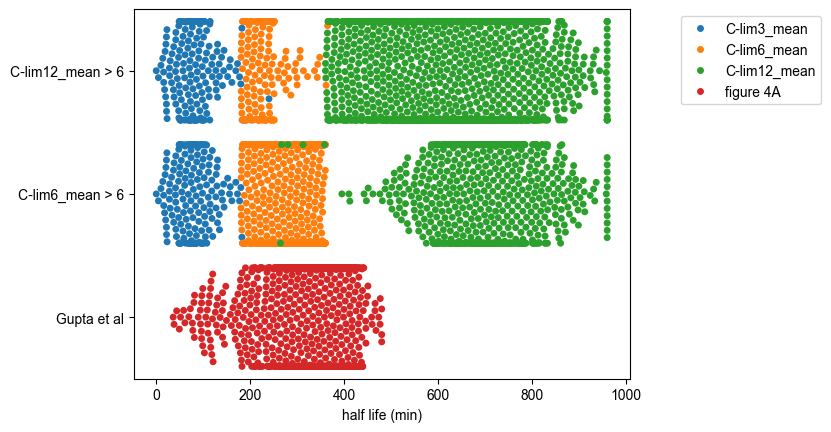

In [148]:
# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=protein_half_lives_df[protein_half_lives_df['source'].isin([ 'C-lim3_mean', 
                                                                                  'C-lim6_mean', 
                                                                                  'C-lim12_mean', 'figure 4A'])], 
                   x= 'half life (min)', y= 'first assignment', hue= 'source')
ax.set(ylabel="");
legend = ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1));

In [2]:
s2_path = '/Users/noravivancogonzalez/Desktop/Gupta2024_TableS2_proteases.xlsx'
table_s2_df = pd.read_excel(s2_path, skiprows=[0, 1, 2, 3])
table_s2_df.drop(columns = ['Unnamed: 0'], inplace = True)

In [3]:
s3_path = '/Users/noravivancogonzalez/Desktop/Gupta2024_TableS3_activ_deg.xlsx'
table_s3_df = pd.read_excel(s3_path, skiprows=[0, 1, 2, 3])
table_s3_df.drop(columns = ['Unnamed: 0'], inplace = True)
Clim6_rapidly_degrading_protein_list = table_s3_df[table_s3_df['Degrading_C6'] == 'yes']['Gene name'].tolist()

In [62]:
s1_path ='/Users/noravivancogonzalez/Desktop/Gupta2024_TableS1.xlsx'
table_s1_df = pd.read_excel(s1_path, skiprows=[0, 1, 2, 3])
df = pd.read_excel(s1_path, nrows=2, skiprows=[0, 1, 2], header = None)
media_condition_dict = dict(zip(df.iloc[1], df.iloc[0]))
clim_df = table_s1_df[['Protein ID', 'Gene names ', 'C-lim3_1', 'C-lim3_2',
       'C-lim6_1', 'C-lim6_2','C-lim12_1','C-lim12_2']] # exclude provided means because we will drop the "celing values"
# Create a deep copy
full_clim_values_df= clim_df.copy(deep=True)

In [63]:
#only dropping row if all clim columns are nan
clim_df.dropna(thresh = 6, inplace = True)
clim_df.reset_index(drop = True, inplace = True)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_92015/3194033723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim_df.dropna(thresh = 6, inplace = True)


In [64]:
#will exclude "ceiling/undetermined values" marked by *
clim_df.loc[:, 'C-lim3_1':'C-lim12_2'] = clim_df.loc[:, 'C-lim3_1':'C-lim12_2'].astype(str)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_92015/2391266706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim_df.loc[:, 'C-lim3_1':'C-lim12_2'] = clim_df.loc[:, 'C-lim3_1':'C-lim12_2'].astype(str)


In [65]:
clim_df = clim_df.applymap(lambda x: None if x.endswith('*') else x)

In [66]:
clim_df.loc[:, 'C-lim3_1':'C-lim12_2'] = clim_df.loc[:, 'C-lim3_1':'C-lim12_2'].astype(float)

In [67]:
clim_df.set_index(['Protein ID','Gene names '], inplace = True)

In [68]:
def find_max_column_custom(row):
    max_value = row.max()
    max_column = row[row == max_value].index[0]
    return max_column

clim_df['max_column'] = clim_df.apply(find_max_column_custom, axis=1)

In [69]:
# Find which proteins did NOT have their max half life in the 12 hr doubling time clim
non_12_mask = (clim_df['max_column'] != 'C-lim12_1') &(clim_df['max_column'] != 'C-lim12_2')
non_12_list = clim_df[non_12_mask].index

In [70]:
list_12 = clim_df[~non_12_mask].index

In [71]:
def calculate_difference(row):
    """Calculates the absolute difference between two values based on the 'max_column', handling NaN values."""

    columns = {'C-lim12': ('C-lim12_1', 'C-lim12_2'),
               'C-lim6': ('C-lim6_1', 'C-lim6_2'),
               'C-lim3': ('C-lim3_1', 'C-lim3_2')}

    for col, (col1, col2) in columns.items():
        if col in row['max_column']:
            return abs(row[col1] - row[col2]) if not np.isnan(row[col1]) and not np.isnan(row[col2]) else np.nan

    return np.nan

In [72]:
clim_df['difference'] = clim_df.apply(calculate_difference, axis=1)

In [106]:
clim_df['notes'] = None

In [109]:
# Keep assignment of max_column if replicates at the chosen doubling time column have a difference less than or equal to 3 hrs
clim_df['notes'][clim_df['difference'] <= 3] = 'consistent'

#262 assigned values have a difference greater than 3 hrs between replicates at the chosen doubling time column
#definitely assign to a value >6, but should it be the mean?
clim_df['notes'][(clim_df['difference']>3) 
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] > 6) & (clim_df['C-lim12_2'] > 6))] = '> 6 hrs, inconsistent'

#assign...clim6 value if both replicates are present? Because clim12 value might be outlier/inconsistent
clim_df['notes'][(clim_df['difference']>3) 
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))
        & ((clim_df['C-lim6_1'] > 3) & (clim_df['C-lim6_2'] > 3))] = '> 3 hrs, inconsistent'

#unsure what to assign, mean? This indicates inconsistent values 
clim_df['notes'][(clim_df['difference']>3) 
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))
        & ((clim_df['C-lim6_1'] < 3) | (clim_df['C-lim6_2'] < 3))] = '< 3 hrs, inconsistent'


#300 assigned large values one have 1 replicate in that doubling time column

clim_df['notes'][clim_df['difference'].isna() 
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] > 6) | (clim_df['C-lim12_2'] > 6))
        & ((clim_df['C-lim6_1'] > 3) & (clim_df['C-lim6_2'] > 3))] = '> 6 hrs, 1 replicate'
#unsure what to assign...clim6 value if both replicates are present? Because clim12 value might be outlier/inconsistent
clim_df['notes'][clim_df['difference'].isna() 
        & clim_df['max_column'].str.contains('C-lim12') 
         & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))
        & ((clim_df['C-lim6_1'] > 3) & (clim_df['C-lim6_2'] > 3))] = '> 3 hrs, 1 replicate'
#unsure what to assign...clim6 or clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['difference'].isna() 
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))
        & ((clim_df['C-lim6_1'] < 3) & (clim_df['C-lim6_2'] < 3))] = '< 3 hrs, 1 replicate'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? 
clim_df['notes'][clim_df['difference'].isna() 
        & clim_df['max_column'].str.contains('C-lim6') 
        & ((clim_df['C-lim6_1'] > 3) | (clim_df['C-lim6_2'] > 3))
        & ((clim_df['C-lim3_1'] > 0) & (clim_df['C-lim3_2'] > 0))] = '> 3 hrs, 1 replicate'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['difference'].isna() 
        & clim_df['max_column'].str.contains('C-lim6') 
        & ((clim_df['C-lim6_1'] < 3) | (clim_df['C-lim6_2'] < 3))
        & ((clim_df['C-lim3_1'] > 0) & (clim_df['C-lim3_2'] > 0))] = '< 3 hrs, 1 replicate'
#unsure what to assign... Mean of all values? Consistent short half life
clim_df['notes'][clim_df['difference'].isna() 
        & clim_df['max_column'].str.contains('C-lim3') 
        & ((clim_df['C-lim3_1'] > 0) | (clim_df['C-lim3_2'] > 0))] = '< 3 hrs, 1 replicate'

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_92015/1453389500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim_df['notes'][clim_df['difference'] <= 3] = 'consistent'
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_92015/1453389500.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim_df['notes'][(clim_df['difference']>3)
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_92015/1453389500.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [125]:
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim6') 
        & ((clim_df['C-lim6_1'] < 3) | (clim_df['C-lim6_2'] < 3))
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))] = '< 3 hrs, inconsistent'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim6') 
        & ((clim_df['C-lim6_1'] > 3) & (clim_df['C-lim6_2'] > 3))
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))] = '> 3 hrs, inconsistent'
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim6') 
        & ((clim_df['C-lim6_1'] > 3) | (clim_df['C-lim6_2'] > 3))
       ] = '> 3 hrs, inconsistent'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] > 6) | (clim_df['C-lim12_2'] > 6))
        & ((clim_df['C-lim6_1'] > 3) | (clim_df['C-lim6_2'] > 3))] = '> 3 hrs, inconsistent'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))
        & ((clim_df['C-lim6_1'] < 3) | (clim_df['C-lim6_2'] < 3))] = '< 3 hrs, inconsistent'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] > 6) | (clim_df['C-lim12_2'] > 6))
        & ((clim_df['C-lim6_1'] < 3) | (clim_df['C-lim6_2'] < 3))] = 'inconsistent'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))
        & ((clim_df['C-lim6_1'] > 3) | (clim_df['C-lim6_2'] > 3))] = '> 3hrs, inconsistent'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] > 6) | (clim_df['C-lim12_2'] > 6))]= '> 3, inconsistent'

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_92015/3101554871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim_df['notes'][clim_df['notes'].isna()


In [143]:
clim_df['notes'] = clim_df['notes'].str.replace('> 3hrs, inconsistent', '> 3 hrs, inconsistent')

In [144]:
clim_df['notes'].unique()

array(['consistent', '> 6 hrs, 1 replicate', '> 3 hrs, inconsistent',
       '> 6 hrs, inconsistent', '< 3 hrs, inconsistent',
       '> 3 hrs, 1 replicate', '< 3 hrs, 1 replicate', 'inconsistent'],
      dtype=object)

In [146]:
#use a dictionary to assign which values to use for the ultimate protein half life
# I will use the median of all available values beyond specified threshold for values that have only 1 replicate or are inconsistent

threshold_dict = {
    'consistent': None, 
    '> 6 hrs, 1 replicate': '> 6', 
    '> 3 hrs, inconsistent': '> 3',
    '> 6 hrs, inconsistent': '> 6', 
    '< 3 hrs, inconsistent': '< 3',
    '> 3 hrs, 1 replicate': '> 3',
    '< 3 hrs, 1 replicate': '< 3',
    'inconsistent': '> 0' }

In [148]:
clim_df['threshold_expr'] = clim_df['notes'].map(threshold_dict)

In [218]:
clim_df.reset_index(inplace = True)

In [219]:
clim_df.columns

Index(['Protein ID', 'Gene names ', 'C-lim3_1', 'C-lim3_2', 'C-lim6_1',
       'C-lim6_2', 'C-lim12_1', 'C-lim12_2', 'max_column', 'difference',
       'notes', 'threshold_expr'],
      dtype='object')

In [214]:
clim_df.columns[6:]

Index(['max_column', 'difference', 'notes', 'threshold_expr'], dtype='object')

In [312]:
clim_long = clim_df[clim_df['notes'] != 'consistent'].melt(id_vars = ['Protein ID', 'Gene names ','notes', 'threshold_expr'], 
             value_vars = ['C-lim3_1', 'C-lim3_2', 'C-lim6_1','C-lim6_2', 'C-lim12_1', 'C-lim12_2'],
             var_name = 'replicate name',
             value_name = 'half life (hrs)').dropna()

In [311]:
clim_long

,Protein ID,Gene names,notes,threshold_expr,replicate name,half life (hrs)
0,sp|P00490|PHSM_ECOLI,malP,"> 6 hrs, 1 replicate",> 6,C-lim3_1,3.244616
1,sp|P00634|PPB_ECOLI,phoA,"> 6 hrs, 1 replicate",> 6,C-lim3_1,3.196812
2,sp|P00803|LEP_ECOLI,lepB,"> 3 hrs, inconsistent",> 3,C-lim3_1,3.629282
3,sp|P00903|PABA_ECOLI,pabA,"> 6 hrs, 1 replicate",> 6,C-lim3_1,3.273867
4,sp|P00954|SYW_ECOLI,trpS,"> 6 hrs, inconsistent",> 6,C-lim3_1,2.860747
...,...,...,...,...,...,...
3367,sp|P77555|ALLD_ECOLI,allD,"> 6 hrs, 1 replicate",> 6,C-lim12_2,NaN
3368,sp|P77579|PTFC1_ECOLI,fryC,"> 6 hrs, 1 replicate",> 6,C-lim12_2,6.395996
3369,sp|P77754|SPY_ECOLI,spy,"> 3 hrs, inconsistent",> 3,C-lim12_2,4.816587
3370,sp|Q46896|CAS1_ECOLI,ygbT,"< 3 hrs, inconsistent",< 3,C-lim12_2,NaN


In [314]:
clim_long['notes'].unique()

array(['> 6 hrs, 1 replicate', '> 3 hrs, inconsistent',
       '> 6 hrs, inconsistent', '< 3 hrs, inconsistent',
       '> 3 hrs, 1 replicate', '< 3 hrs, 1 replicate', 'inconsistent'],
      dtype=object)

In [315]:
#if threshold above 6 then make half life <=6 = nan within that selection
clim_long['half life (hrs)'][(clim_long['threshold_expr']=='> 6') &(clim_long['half life (hrs)'] <= 6)]= np.nan
#if threshold above 3 then make half life <=3 = nan within that selection
clim_long['half life (hrs)'][(clim_long['threshold_expr']=='> 3') &(clim_long['half life (hrs)'] <= 3)]= np.nan
#if threshold below 3 then make half life >=3 = nan within that selection
clim_long['half life (hrs)'][(clim_long['threshold_expr']=='< 3') &(clim_long['half life (hrs)'] >= 3)]= np.nan

In [316]:
clim_long.dropna(inplace = True)

In [317]:
clim_long.columns

Index(['Protein ID', 'Gene names ', 'notes', 'threshold_expr',
       'replicate name', 'half life (hrs)'],
      dtype='object')

In [318]:
#if half life is not consistent, choose the median among available values per category in Protein ID
inconsistent_protein_medians = clim_long.groupby(['Protein ID', 'Gene names ','notes',
       'threshold_expr' ])['half life (hrs)'].median().reset_index()

In [319]:
inconsistent_protein_medians

,Protein ID,Gene names,notes,threshold_expr,half life (hrs)
0,sp|P00490|PHSM_ECOLI,malP,"> 6 hrs, 1 replicate",> 6,7.155026
1,sp|P00634|PPB_ECOLI,phoA,"> 6 hrs, 1 replicate",> 6,9.891235
2,sp|P00803|LEP_ECOLI,lepB,"> 3 hrs, inconsistent",> 3,4.771535
3,sp|P00903|PABA_ECOLI,pabA,"> 6 hrs, 1 replicate",> 6,8.09855
4,sp|P00954|SYW_ECOLI,trpS,"> 6 hrs, inconsistent",> 6,10.607478
...,...,...,...,...,...
557,sp|Q46925|CSDA_ECOLI,csdA,"> 6 hrs, inconsistent",> 6,10.777675
558,sp|Q47083|CBL_ECOLI,cbl,"< 3 hrs, 1 replicate",< 3,1.162972
559,sp|Q47537|TAUA_ECOLI,tauA,"> 6 hrs, inconsistent",> 6,11.389587
560,sp|Q47679|YAFV_ECOLI,yafV,"> 6 hrs, inconsistent",> 6,11.746857


In [320]:
consistent_clim_df = clim_df[clim_df['notes'] == 'consistent'].melt(id_vars = ['Protein ID', 'Gene names ','max_column', 'notes'], 
             value_vars = ['C-lim3_1', 'C-lim3_2', 'C-lim6_1','C-lim6_2', 'C-lim12_1', 'C-lim12_2'],
             var_name = 'replicate name',
             value_name = 'half life (hrs)').dropna()

In [321]:
#only keep half life with replicate name that matches max_column
consistent_protein_medians = consistent_clim_df[consistent_clim_df['max_column']== consistent_clim_df['replicate name']]

In [322]:
consistent_protein_medians.rename(columns = {'max_column': 'assignment'}, inplace = True)
inconsistent_protein_medians.rename(columns = {'threshold_expr': 'assignment'}, inplace = True)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_92015/4207001057.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consistent_protein_medians.rename(columns = {'max_column': 'assignment'}, inplace = True)


In [323]:
gupta_protein_half_lifes = pd.concat([consistent_protein_medians[['Protein ID', 'Gene names ', 'notes', 'assignment', 'half life (hrs)']], 
                                      inconsistent_protein_medians])

In [324]:
final_path = '/Users/noravivancogonzalez/Desktop/Gupta2024_NV_assigned_protein_half_lives.csv'
gupta_protein_half_lifes.to_csv(final_path, index=False)

In [325]:
gupta_protein_half_lifes

,Protein ID,Gene names,notes,assignment,half life (hrs)
450,sp|P0A9P6|DEAD_ECOLI,deaD,consistent,C-lim3_1,1.642305
472,sp|P0A9X9|CSPA_ECOLI,cspA,consistent,C-lim3_1,1.793323
654,sp|P0ADG1|ILVM_ECOLI,ilvM,consistent,C-lim3_1,1.244372
1046,sp|P24216|FLID_ECOLI,fliD,consistent,C-lim3_1,1.485761
1180,sp|P32053|INTA_ECOLI,intA,consistent,C-lim3_1,1.3136
...,...,...,...,...,...
557,sp|Q46925|CSDA_ECOLI,csdA,"> 6 hrs, inconsistent",> 6,10.777675
558,sp|Q47083|CBL_ECOLI,cbl,"< 3 hrs, 1 replicate",< 3,1.162972
559,sp|Q47537|TAUA_ECOLI,tauA,"> 6 hrs, inconsistent",> 6,11.389587
560,sp|Q47679|YAFV_ECOLI,yafV,"> 6 hrs, inconsistent",> 6,11.746857


In [ ]:
# i need to figure out how to match the chosen median value to the chemostat condition it was growing in

In [ ]:
gupta_protein_half_lifes

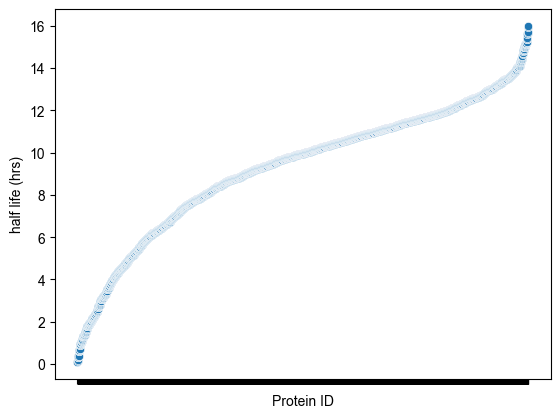

In [326]:
ax = sns.scatterplot(x='Protein ID', y='half life (hrs)',
                     data= gupta_protein_half_lifes.sort_values(by='half life (hrs)'))

# Set the y-axis labels to an empty list
ax.set_xticklabels([])

plt.show()

/Users/noravivancogonzalez/.pyenv/versions/3.11.3/envs/wcEcoli3-11/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 83.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/noravivancogonzalez/.pyenv/versions/3.11.3/envs/wcEcoli3-11/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 35.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/noravivancogonzalez/.pyenv/versions/3.11.3/envs/wcEcoli3-11/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 25.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/noravivancogonzalez/.pyenv/versions/3.11.3/envs/wcEcoli3-11/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 44.0% of the points cannot be p

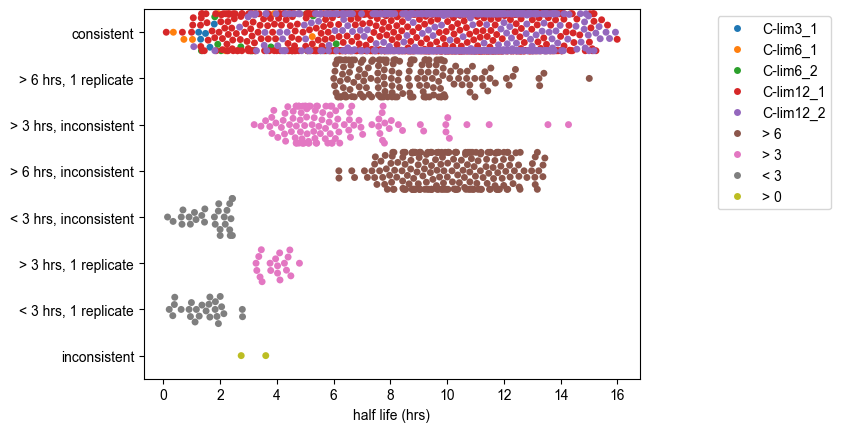

In [327]:
# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=gupta_protein_half_lifes, 
                   x= 'half life (hrs)', y= 'notes', hue= 'assignment')
ax.set(ylabel="");
legend = ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1));

In [329]:
clim_long_all_values= clim_df.melt(id_vars = ['Protein ID', 'Gene names ','notes', 'threshold_expr'], 
             value_vars = ['C-lim3_1', 'C-lim3_2', 'C-lim6_1','C-lim6_2', 'C-lim12_1', 'C-lim12_2'],
             var_name = 'replicate name',
             value_name = 'half life (hrs)')

In [336]:
clim_long_all_values['notes'].unique()

array(['consistent', '> 6 hrs, 1 replicate', '> 3 hrs, inconsistent',
       '> 6 hrs, inconsistent', '< 3 hrs, inconsistent',
       '> 3 hrs, 1 replicate', '< 3 hrs, 1 replicate', 'inconsistent'],
      dtype=object)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_92015/3859612093.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');


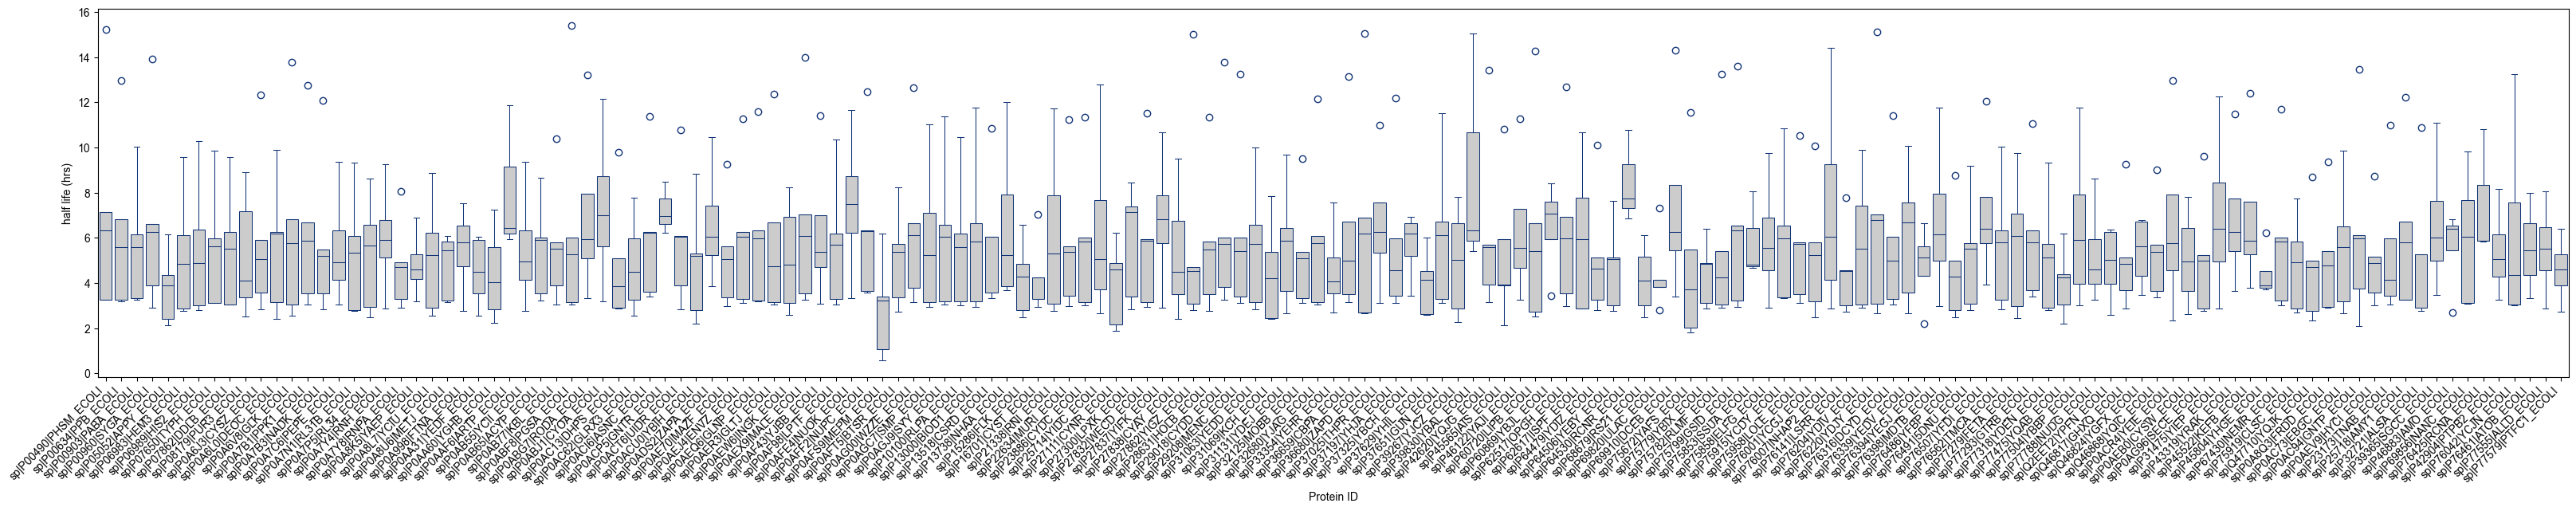

In [342]:
fig, ax = plt.subplots(figsize=(40, 6))
sns.boxplot(data=clim_long_all_values[clim_long_all_values['notes']=='> 6 hrs, 1 replicate'], 
            x='Protein ID', y='half life (hrs)', color='.8', linecolor='#137', linewidth=.75, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

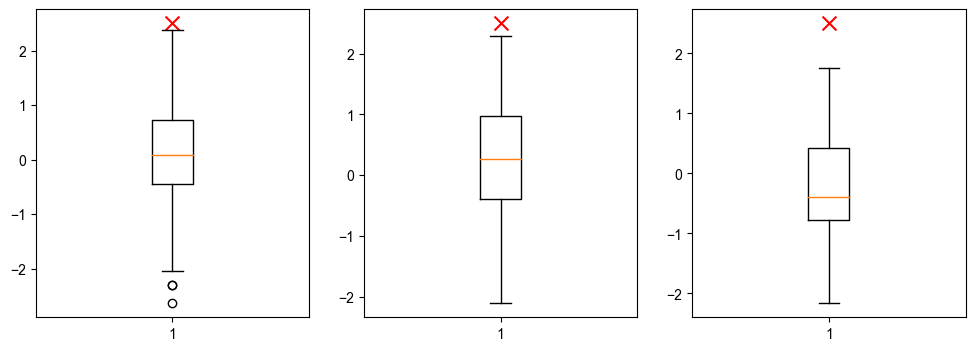

In [343]:
# Sample data for multiple datasets
data1 = np.random.randn(100)
data2 = np.random.randn(100)
data3 = np.random.randn(100)

# Value to highlight
value_to_highlight = 2.5

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot box plots and highlight the value in each plot
for ax, data in zip(axes, [data1, data2, data3]):
    ax.boxplot(data)
    ax.scatter(1, value_to_highlight, color='red', marker='x', s=100)

plt.show()

In [338]:
len(clim_long_all_values[clim_long_all_values['notes']=='> 6 hrs, 1 replicate']['Protein ID'].unique())

159

In [285]:
clim_df[clim_df['threshold_expr']== '> 0'].melt(id_vars = ['Protein ID', 'Gene names ','max_column', 'difference', 'notes', 'threshold_expr'], 
             value_vars = ['C-lim3_1', 'C-lim3_2', 'C-lim6_1','C-lim6_2', 'C-lim12_1', 'C-lim12_2'],
             var_name = 'replicate name',
             value_name = 'half life (hrs)')

,Protein ID,Gene names,max_column,difference,notes,threshold_expr,replicate name,half life (hrs)
0,sp|P0AAC4|YBHL_ECOLI,ybhL,C-lim12_1,NaN,inconsistent,> 0,C-lim3_1,1.794778
1,sp|P41052|MLTB_ECOLI,mltB,C-lim12_2,NaN,inconsistent,> 0,C-lim3_1,NaN
2,sp|P0AAC4|YBHL_ECOLI,ybhL,C-lim12_1,NaN,inconsistent,> 0,C-lim3_2,2.506152
3,sp|P41052|MLTB_ECOLI,mltB,C-lim12_2,NaN,inconsistent,> 0,C-lim3_2,3.60814
4,sp|P0AAC4|YBHL_ECOLI,ybhL,C-lim12_1,NaN,inconsistent,> 0,C-lim6_1,2.979307
5,sp|P41052|MLTB_ECOLI,mltB,C-lim12_2,NaN,inconsistent,> 0,C-lim6_1,2.346038
6,sp|P0AAC4|YBHL_ECOLI,ybhL,C-lim12_1,NaN,inconsistent,> 0,C-lim6_2,NaN
7,sp|P41052|MLTB_ECOLI,mltB,C-lim12_2,NaN,inconsistent,> 0,C-lim6_2,NaN
8,sp|P0AAC4|YBHL_ECOLI,ybhL,C-lim12_1,NaN,inconsistent,> 0,C-lim12_1,6.016077
9,sp|P41052|MLTB_ECOLI,mltB,C-lim12_2,NaN,inconsistent,> 0,C-lim12_1,NaN


In [12]:
# this is the sorting I prefer
hr_assignment_12 = clim_df['C-lim12_mean']> 6
clim_df.loc[hr_assignment_12, ['C-lim3_1', 'C-lim3_2',
                                             'C-lim3_mean', 'C-lim6_1', 
                                             'C-lim6_2', 'C-lim6_mean',]] = np.nan
hr_assignment_6 = clim_df['C-lim6_mean']> 3
clim_df.loc[hr_assignment_6, ['C-lim3_1', 'C-lim3_2',
                                            'C-lim3_mean','C-lim12_1', 
                                            'C-lim12_2', 'C-lim12_mean']] = np.nan
hr_assignment_3 = clim_df['C-lim3_mean']> 0
clim_df.loc[hr_assignment_3, ['C-lim6_1', 'C-lim6_2', 
                                            'C-lim6_mean','C-lim12_1', 
                                            'C-lim12_2', 'C-lim12_mean']] = np.nan

clim_12g6_assignment_df = clim_df.melt(id_vars = clim_df.columns[:2], 
                                                   value_vars = clim_df.columns[2:]).dropna()
clim_12g6_assignment_df.reset_index(drop = True, inplace = True)

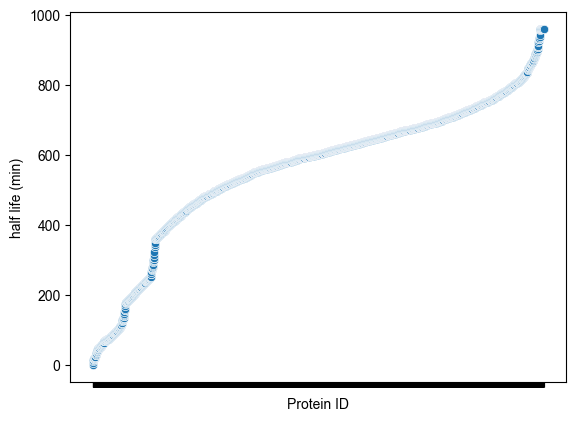

In [14]:
clim_12g6_assignment_df['half life (min)'] = clim_12g6_assignment_df['value']*60
ax = sns.scatterplot(x='Protein ID', y='half life (min)',
                     data=clim_12g6_assignment_df[clim_12g6_assignment_df['variable'].isin([ 'C-lim3_mean', 'C-lim6_mean', 'C-lim12_mean'])].sort_values(by='half life (min)'))

# Set the y-axis labels to an empty list
ax.set_xticklabels([])

plt.show()

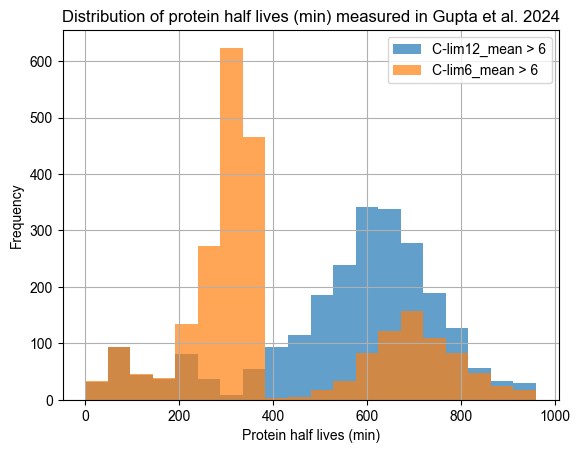

In [24]:
clim_12g6_assignment_df['half life (min)'][clim_12g6_assignment_df['variable'].isin([ 'C-lim3_mean', 'C-lim6_mean', 'C-lim12_mean'])].hist(bins=20, alpha=0.7, label='C-lim12_mean > 6')
clim_6g6_assignment_df['half life (min)'][clim_6g6_assignment_df['variable'].isin([ 'C-lim3_mean', 'C-lim6_mean', 'C-lim12_mean'])].hist(bins=20, alpha=0.7, label='C-lim6_mean > 6')
plt.legend()
plt.xlabel('Protein half lives (min)')
plt.ylabel('Frequency')
plt.title('Distribution of protein half lives (min) measured in Gupta et al. 2024')
plt.show()

In [26]:
both_assignments_df.head(5)

,Protein ID,Gene names,variable,value,half life (min),first assignment
0,sp|P00888|AROF_ECOLI,aroF,C-lim3_1,2.291727,137.503595,C-lim12_mean > 6
1,sp|P00936|CYAA_ECOLI,cyaA,C-lim3_1,0.834197,50.051837,C-lim12_mean > 6
2,sp|P00963|ASNA_ECOLI,asnA,C-lim3_1,2.472654,148.359258,C-lim12_mean > 6
3,sp|P03007|DPO3E_ECOLI,dnaQ,C-lim3_1,0.859817,51.588998,C-lim12_mean > 6
4,sp|P04395|3MG2_ECOLI,alkA,C-lim3_1,2.436145,146.16873,C-lim12_mean > 6


In [58]:
x = clim_12g6_assignment_df[clim_12g6_assignment_df['variable'].isin([ 'C-lim3_mean', 'C-lim6_mean', 'C-lim12_mean'])]
y = clim_6g6_assignment_df[clim_6g6_assignment_df['variable'].isin([ 'C-lim3_mean', 'C-lim6_mean', 'C-lim12_mean'])]
x.set_index('Gene names ', inplace = True)
y.set_index('Gene names ', inplace = True)

In [150]:
clim_fig4_df.set_index('Gene names ', inplace = True)

In [151]:
extra_wide = pd.merge(wide_table_deg, clim_fig4_df, left_index=True, right_index=True, suffixes=('_', '_Gupta'))

In [59]:
wide_table_deg = pd.merge(x, y, left_index=True, right_index=True, suffixes=('_12>6', '_6>6'))

In [152]:
extra_wide.head(5)

,Protein ID_12>6,variable_12>6,value_12>6,half life (min)_12>6,first assignment_12>6,Protein ID_6>6,variable_6>6,value_6>6,half life (min)_6>6,first assignment_6>6,assignment,rapidly degrading at clim 6,Protein ID,half life (hrs),half life (min),source,first assignment
Gene names,,,,,,,,,,,,,,,,,
asnA,sp|P00963|ASNA_ECOLI,C-lim3_mean,2.533061,151.983637,C-lim12_mean > 6,sp|P00963|ASNA_ECOLI,C-lim3_mean,2.533061,151.983637,C-lim6_mean > 6,same,no,sp|P00963|ASNA_ECOLI,2.896774,173.806427,figure 4A,Gupta et al
dnaQ,sp|P03007|DPO3E_ECOLI,C-lim3_mean,0.846563,50.793769,C-lim12_mean > 6,sp|P03007|DPO3E_ECOLI,C-lim3_mean,0.846563,50.793769,C-lim6_mean > 6,same,no,sp|P03007|DPO3E_ECOLI,2.131885,127.913108,figure 4A,Gupta et al
fliC,sp|P04949|FLIC_ECOLI,C-lim3_mean,0.717108,43.026486,C-lim12_mean > 6,sp|P04949|FLIC_ECOLI,C-lim3_mean,0.717108,43.026486,C-lim6_mean > 6,same,no,sp|P04949|FLIC_ECOLI,0.723554,43.413227,figure 4A,Gupta et al
ftsQ,sp|P06136|FTSQ_ECOLI,C-lim3_mean,2.599243,155.954559,C-lim12_mean > 6,sp|P06136|FTSQ_ECOLI,C-lim3_mean,2.599243,155.954559,C-lim6_mean > 6,same,no,sp|P06136|FTSQ_ECOLI,2.960501,177.630046,figure 4A,Gupta et al
iscS,sp|P0A6B7|ISCS_ECOLI,C-lim3_mean,2.232851,133.971052,C-lim12_mean > 6,sp|P0A6B7|ISCS_ECOLI,C-lim3_mean,2.232851,133.971052,C-lim6_mean > 6,same,no,sp|P0A6B7|ISCS_ECOLI,2.782960,166.977584,figure 4A,Gupta et al


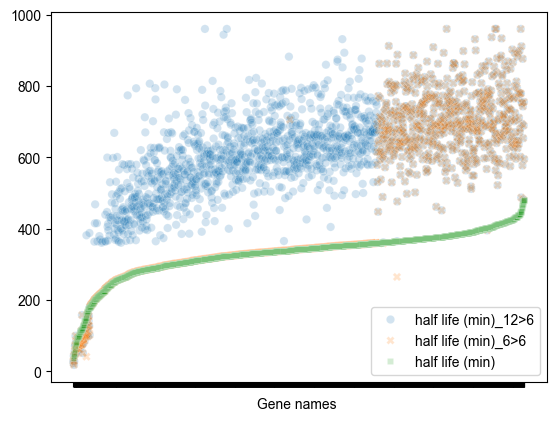

In [155]:
ax = sns.scatterplot(data = extra_wide[['half life (min)_12>6', 'half life (min)_6>6','half life (min)']].sort_values(by='half life (min)'), 
                     alpha=0.2)
ax.set_xticklabels([])
plt.show()

In [154]:
# nearly half of the values remain the same
wide_table_deg['assignment'] = 'different'
mask_same = wide_table_deg['half life (min)_12>6'] == wide_table_deg['half life (min)_6>6']
wide_table_deg['assignment'][mask_same] = 'same'

In [173]:
full_chosen_df['half life (hrs)'] = full_chosen_df['half life (hrs)'].round(decimals=2)
full_chosen_df['C-lim6_mean'] = full_chosen_df['C-lim6_mean'].round(decimals=2)

full_chosen_df['assignment'] = 'different'
mask_same = full_chosen_df['half life (hrs)'] == full_chosen_df['C-lim6_mean']
full_chosen_df['assignment'][mask_same] = 'same'

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_33726/3139375122.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_chosen_df['assignment'][mask_same] = 'same'


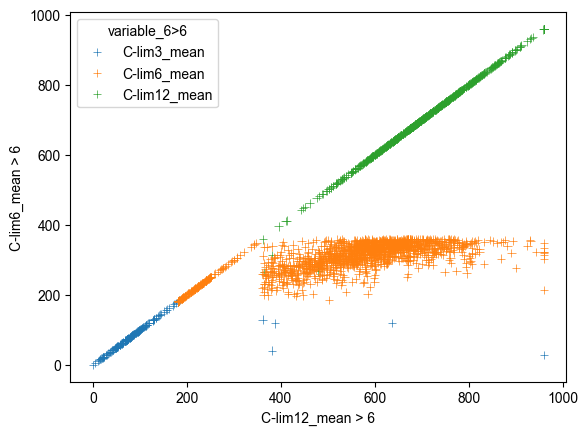

In [77]:
ax = sns.scatterplot(x='half life (min)_12>6', y='half life (min)_6>6', data = wide_table_deg, hue = 'variable_6>6', marker ='+')

plt.xlabel('C-lim12_mean > 6')
plt.ylabel('C-lim6_mean > 6')

plt.show()

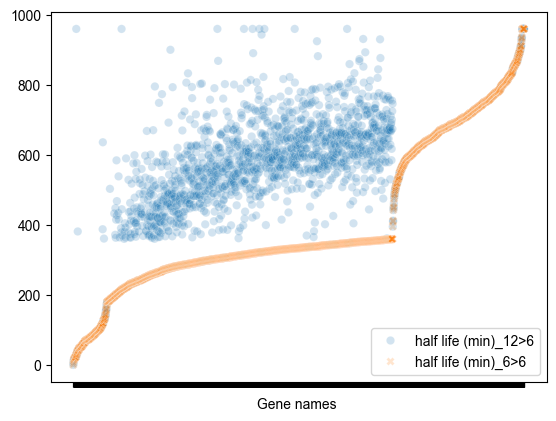

In [83]:
ax = sns.scatterplot(data = wide_table_deg[['half life (min)_12>6', 'half life (min)_6>6']].sort_values(by='half life (min)_6>6'), 
                     alpha=0.2)
ax.set_xticklabels([])
plt.show()

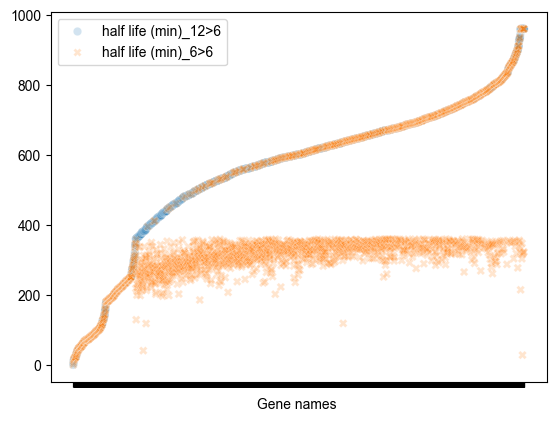

In [84]:
ax = sns.scatterplot(data = wide_table_deg[['half life (min)_12>6', 'half life (min)_6>6']].sort_values(by='half life (min)_12>6'), 
                     alpha=0.2)
ax.set_xticklabels([])
plt.show()

In [102]:
wide_table_deg['rapidly degrading at clim 6'] = 'no'
wide_table_deg['rapidly degrading at clim 6'][wide_table_deg.index.isin(Clim6_rapidly_degrading_protein_list)] = 'yes'

In [103]:
wide_table_deg['rapidly degrading at clim 6'].unique()

array(['no', 'yes'], dtype=object)

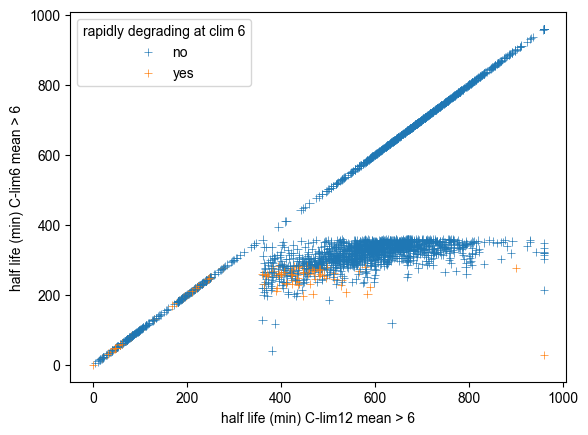

In [112]:
ax = sns.scatterplot(x='half life (min)_12>6', y='half life (min)_6>6', data = wide_table_deg, hue = 'rapidly degrading at clim 6', marker ='+')

plt.xlabel('half life (min) C-lim12 mean > 6')
plt.ylabel('half life (min) C-lim6 mean > 6')

plt.show()

In [124]:
mask_3 = (wide_table_deg['value_6>6'] <3)

In [119]:
wide_table_deg.head(5)

,Protein ID_12>6,variable_12>6,value_12>6,half life (min)_12>6,first assignment_12>6,Protein ID_6>6,variable_6>6,value_6>6,half life (min)_6>6,first assignment_6>6,assignment,rapidly degrading at clim 6
Gene names,,,,,,,,,,,,
aroF,sp|P00888|AROF_ECOLI,C-lim3_mean,2.241979,134.518723,C-lim12_mean > 6,sp|P00888|AROF_ECOLI,C-lim3_mean,2.241979,134.518723,C-lim6_mean > 6,same,no
cyaA,sp|P00936|CYAA_ECOLI,C-lim3_mean,0.844836,50.690132,C-lim12_mean > 6,sp|P00936|CYAA_ECOLI,C-lim3_mean,0.844836,50.690132,C-lim6_mean > 6,same,no
asnA,sp|P00963|ASNA_ECOLI,C-lim3_mean,2.533061,151.983637,C-lim12_mean > 6,sp|P00963|ASNA_ECOLI,C-lim3_mean,2.533061,151.983637,C-lim6_mean > 6,same,no
dnaQ,sp|P03007|DPO3E_ECOLI,C-lim3_mean,0.846563,50.793769,C-lim12_mean > 6,sp|P03007|DPO3E_ECOLI,C-lim3_mean,0.846563,50.793769,C-lim6_mean > 6,same,no
alkA,sp|P04395|3MG2_ECOLI,C-lim3_mean,2.318513,139.110789,C-lim12_mean > 6,sp|P04395|3MG2_ECOLI,C-lim3_mean,2.318513,139.110789,C-lim6_mean > 6,same,no


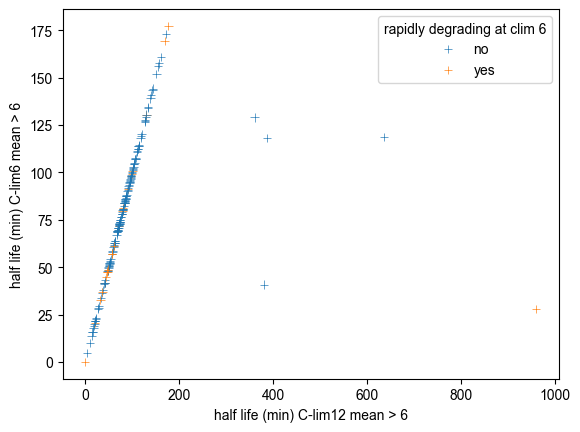

In [125]:
ax = sns.scatterplot(x='half life (min)_12>6', y='half life (min)_6>6', data = wide_table_deg[mask_3],
                     hue = 'rapidly degrading at clim 6', marker ='+')

plt.xlabel('half life (min) C-lim12 mean > 6')
plt.ylabel('half life (min) C-lim6 mean > 6')

plt.show()